# Decomposing a full-sky catalog

In this notebooks we show how to decompose a catalog defined on the full-sky into an ensemble of flat-sky patches.

In [1]:
from astropy.table import Table
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt

import orpheus

## Prepare a mock Catalog

This is a helper function that generates a simplistic full-sky mock given a mask consisting of a large-scale footprint and some smaller cut-out circles. For the purpuse of this notebook positions are sufficient such that we do not include any tracers.

In [2]:
def gen_mock(nbar_arcmin2, nside_hp, rseed, nside_mask, nmask, r_mean, r_std):

    # Sample random points
    npoints = int(41_252.96*3600*nbar_arcmin2)
    np.random.seed(rseed)
    rand_ra = np.random.uniform(0, 2*np.pi, npoints)
    rand_sindec = np.random.uniform(np.sin(-np.pi/2), np.sin(np.pi/2), npoints)
    rand_dec = np.arcsin(rand_sindec)

    # Large scale footprint
    bigmask = np.ones(npoints, dtype=bool)
    bigmask *= rand_ra < 2*np.pi/3
    bigmask *= ((rand_ra + 2*rand_dec) < .7*np.pi)
    bigmask *= ~(((rand_ra-.4*rand_dec) > 70*np.pi/180) * ((rand_ra-.4*rand_dec) < 80*np.pi/180))

    # Smaller cutouts
    rrad = np.abs(np.random.normal(loc=r_mean,scale=r_std,size=nmask))
    rind = np.random.randint(hp.nside2npix(nside_mask),size=nmask)
    smallmask = set({})
    for imask in range(nmask):
        nextmask = hp.query_disc(nside=nside_mask, vec=hp.pix2vec(ipix=rind[imask],nside=nside_mask), radius=rrad[imask]*np.pi/180.)
        smallmask = smallmask.union(nextmask)
    smallmask = list(smallmask)
    smallmask_map = np.ones(hp.nside2npix(nside_mask))
    smallmask_map[smallmask] = 0

    # Map the angular positions on healpix grid and check which ones lie in masked regions
    hpinds_maskmap, hpinds_onmask = orpheus.cat2hpx(lon= rand_ra[bigmask]*180./np.pi, lat=rand_dec[bigmask]*180./np.pi, nside=nside_mask, return_indices=True)
    unmasked = (hpinds_onmask*smallmask_map[hpinds_onmask]).astype(bool)
    # Retrieve healpix indices and map for the same resolution as for the T17 map
    ra_unmasked = rand_ra[bigmask][unmasked]*180./np.pi
    dec_unmasked = rand_dec[bigmask][unmasked]*180./np.pi
    hpinds_map, hpinds_data = orpheus.cat2hpx(lon=ra_unmasked, lat=dec_unmasked, nside=nside_hp, return_indices=True)

    return ra_unmasked, dec_unmasked, hpinds_map, hpinds_data


Generate the mock and plot the footprint

In [3]:
nbar_arcmin2 = 0.5 # Number density of tracers in the mock
nside_hp = 8192 # Angular resolution of map of tracers
rseed = 42 # Random seed used in the initialization of the random points and the mask
nside_mask = 512 # Nside used for the creation of the mask
nmask = 200 # Number of circle-shaped holes in the fullsky
r_mean = 5 # Mean radius of a hole in degrees
r_std = 0.3 # Std of the radius of a hole in degrees

ra_unmasked, dec_unmasked, hpinds_map, hpinds_data = gen_mock(nbar_arcmin2=nbar_arcmin2,
                                                              nside_hp=nside_hp,
                                                              rseed=rseed,
                                                              nside_mask=nside_mask,
                                                              nmask=nmask, 
                                                              r_mean=r_mean, 
                                                              r_std=r_std)

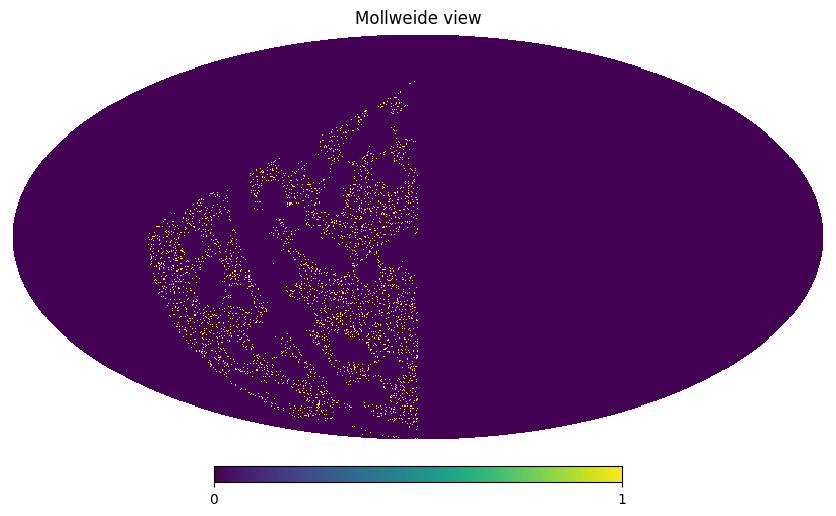

In [4]:
hp.mollview(hpinds_map)

## Decomposing the catalog into patches

We first need to initialise an instance of `orpheus.Catalog` or any child thereof.

In [5]:
fcat = orpheus.ScalarTracerCatalog(pos1=ra_unmasked, pos2=dec_unmasked, tracer=np.ones_like(ra_unmasked),
                                   units_pos1='deg', units_pos2='deg', geometry='spherical')
fcat.ngal

11613230

Now, we decompose the catalog into patches using the `sklearn.cluster.KMeans` function. _(To speed up the computation for high-$\overline{n}$ catalogs we first grid the catalog on a healpix grid)_. The main two parameters that should to be adjusted based on the survey setting are
* npatches: In how many patches shall the catalog be decomposed? Usually, one should aim for patches of a sidelength of ~5-10 degrees.
* patchextend_deg: After the patches are defined we allocate a buffer region of radius `patchextend_deg` degrees around each patch. This is required to take into account multiplet counts across different patches in a NPCF estimation.

By setting the `verbose` argument to `True` we can get some more progress- and timing information for the individual steps within the creation of the patches

In [6]:
npatches = 100
fcat.topatches(npatches, 
               patchextend_deg=2.0,
               verbose=True)

Computing inner region of patches
Took 53.479 seconds
Mapping catalog to healpix grid
Took 0.843 seconds
Building index hash
Took 1.054 seconds
Building buffer around patches
100/100Took 14.490 seconds


Let us now visualize the results. We show:
* The area of the individual patches in square degrees. We can see that there is a substantial standard deviation across the patch size, but this might partially be due to the fairly complex geometry of the footprint. _(I have also compared with `treecorr`'s implementation and found a similar performance)._

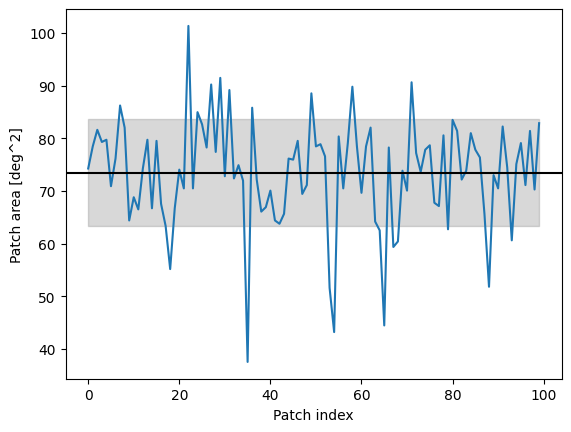

S/N of areas: 7.20


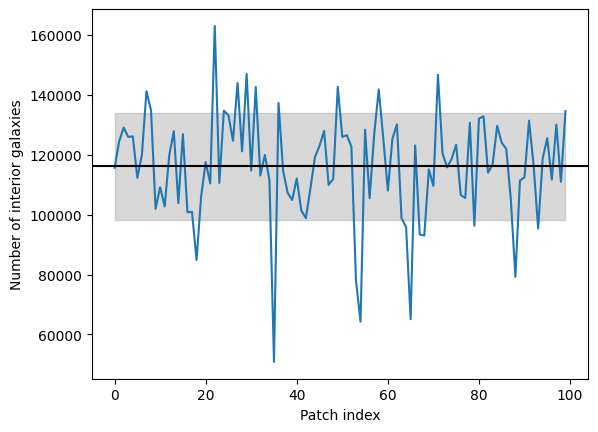

S/N of counts: 6.53


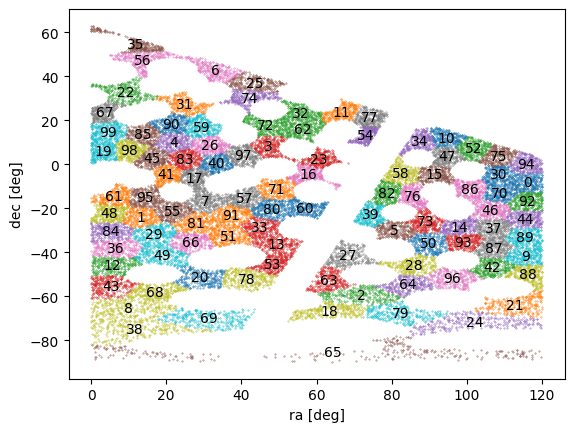

In [7]:
# Plot individual areas
_areas = fcat.patchinds['info']['patchareas']
plt.plot(_areas)
plt.axhline(np.mean(_areas),color='black')
plt.fill_between(x=np.arange(npatches),
                 y1=(np.mean(_areas)-np.std(_areas))*np.ones(npatches),
                 y2=(np.mean(_areas)+np.std(_areas))*np.ones(npatches),
                 color='grey',alpha=0.3)
plt.xlabel('Patch index')
plt.ylabel('Patch area [deg^2]')
plt.show()
print('S/N of areas: %.2f'%(np.mean(_areas)/np.std(_areas)))

# Plot number of inner galaxies
_countsi = fcat.patchinds['info']['patch_ngalsinner']
plt.plot(_countsi)
plt.axhline(np.mean(_countsi),color='black')
plt.fill_between(x=np.arange(npatches),
                 y1=(np.mean(_countsi)-np.std(_countsi))*np.ones(npatches),
                 y2=(np.mean(_countsi)+np.std(_countsi))*np.ones(npatches),
                 color='grey',alpha=0.3)
plt.xlabel('Patch index')
plt.ylabel('Number of interior galaxies')
plt.show()
print('S/N of counts: %.2f'%(np.mean(_countsi)/np.std(_countsi)))

# Plot the full footprint with a subselection of galaxies in each patch
for elpatch in range(npatches):
    plt.scatter(fcat.pos1[fcat.patchinds["patches"][elpatch]['inner']][:300],fcat.pos2[fcat.patchinds["patches"][elpatch]['inner']][:300],s=0.1)
    plt.text(x=fcat.patchinds['info']['patchcenters'][elpatch,0], y=fcat.patchinds['info']['patchcenters'][elpatch,1], s=str(elpatch), 
             horizontalalignment='center', verticalalignment='center')
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.show()


Let us now take a look at a flat-sky projection of a single patch, which can be done by using the `frompatchind` method of any child of a `Catalog` instance. The blue points show tracers within the interior of the patch while the orange points indicate the buffer region. Also note that the center of the patch is located at the center-of-mass of the tracers within the _interior_ of the patch.

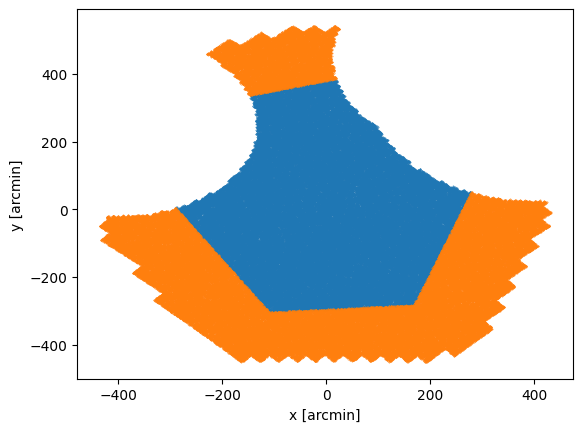

222734

In [8]:
index = 73
patchcat = fcat.frompatchind(index=index)
plt.scatter(patchcat.pos1[patchcat.isinner.astype(bool)],patchcat.pos2[patchcat.isinner.astype(bool)],s=0.1)
plt.scatter(patchcat.pos1[~patchcat.isinner.astype(bool)],patchcat.pos2[~patchcat.isinner.astype(bool)],s=0.1)
plt.xlabel('x [arcmin]')
plt.ylabel('y [arcmin]')
plt.show()

patchcat.ngal

## Repeating the analysis for multiple catalogs

When dealing with the estimation of NPCFs using multipole catalogs (such as galaxy-galaxy-galaxy-lensing), we need to construct patches that are matching across the all those catalogs which might have very different footprints etc. Creating such a patch decomposition is also possible in `orpheus`.

Let us first create two other mock catalogs using different masks and tracer number densities and initialise their corresponding `ScalarTracerCatalog` instances.

In [9]:
# Mock catalog variation b
nbar_arcmin2_b = 0.1
rseed_b = 67
nmask_b = 100
r_mean_b = 5
r_std_b = 0.3
ra_unmasked_b, dec_unmasked_b, hpinds_map_b, hpinds_data_b = gen_mock(nbar_arcmin2=nbar_arcmin2_b,
                                                              nside_hp=nside_hp,
                                                              rseed=rseed_b,
                                                              nside_mask=nside_mask,
                                                              nmask=nmask_b, 
                                                              r_mean=r_mean_b, 
                                                              r_std=r_std_b)

# Mock catalog variation c
nbar_arcmin2_c = 0.2
rseed_c = 89
nmask_c = 140
r_mean_c = 7
r_std_c = 0.3
ra_unmasked_c, dec_unmasked_c, hpinds_map_c, hpinds_data_c = gen_mock(nbar_arcmin2=nbar_arcmin2_c,
                                                              nside_hp=nside_hp,
                                                              rseed=rseed_c,
                                                              nside_mask=nside_mask,
                                                              nmask=nmask_c, 
                                                              r_mean=r_mean_c, 
                                                              r_std=r_std_c)

In [10]:
fcatb = orpheus.ScalarTracerCatalog(pos1=ra_unmasked_b, pos2=dec_unmasked_b, tracer=np.ones_like(ra_unmasked_b),
                                   units_pos1='deg', units_pos2='deg', geometry='spherical')

fcatc = orpheus.ScalarTracerCatalog(pos1=ra_unmasked_c, pos2=dec_unmasked_c, tracer=np.ones_like(ra_unmasked_c),
                                   units_pos1='deg', units_pos2='deg', geometry='spherical')
fcat.ngal, fcatb.ngal, fcatc.ngal

(11613230, 3000975, 3949281)

Creating matches for all catalogs can again be achieved using the `topatches` method of any of the `Catalog` child instances. The only thing that needs to be done is to add the remaining instances to the `other_cats` parameter. 

In [11]:
npatches = 120
fcat.topatches(npatches, 
               patchextend_deg=3.0,
               other_cats=[fcatb,fcatc],
               verbose=True)

Computing inner region of patches
Took 109.150 seconds
Mapping catalog to healpix grid
Took 1.484 seconds
Building index hash
Took 2.092 seconds
Building buffer around patches
120/120Took 32.202 seconds


Now, let us plot the flat-sky projection of the same patch for each catalog. We first look at the inner region:
* We immediately see that the overall shape of the patch matches across all different catalogs even though the masks can affect the tracer distribution within this patch significiantly
* The patch is centered at the center-of-mass of the _union_ of all three catalogs. The centers-of-mass of the individual patches are shown as the large crosses with the size of each cross being proportional to the weight of the corresponding catalog within the patch. 

Similarly, we see that the buffer regions of the individual patches are also matched across all three catalogs.

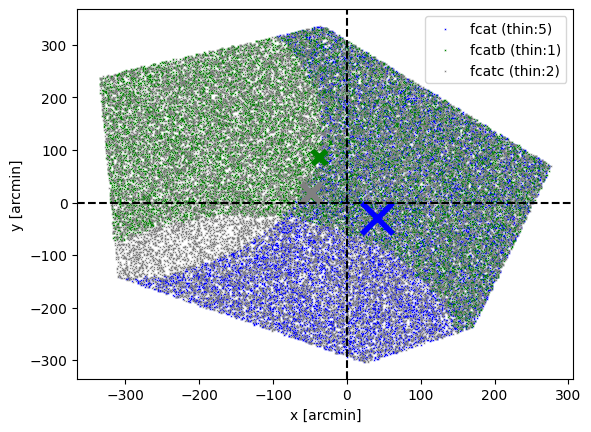

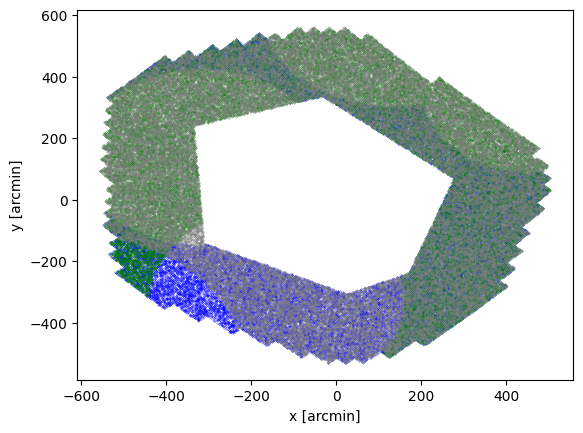

In [12]:
index = 35
patchcat = fcat.frompatchind(index=index)
patchcatb = fcatb.frompatchind(index=index)
patchcatc = fcatc.frompatchind(index=index)

plt.scatter(patchcat.pos1[patchcat.isinner.astype(bool)][::5],patchcat.pos2[patchcat.isinner.astype(bool)][::5],s=0.1,color='blue',marker='x',label='fcat (thin:5)')
plt.scatter(patchcatb.pos1[patchcatb.isinner.astype(bool)][::1],patchcatb.pos2[patchcatb.isinner.astype(bool)][::1],s=0.1,color='green',marker='x',label='fcatb (thin:1)')
plt.scatter(patchcatc.pos1[patchcatc.isinner.astype(bool)][::2],patchcatc.pos2[patchcatc.isinner.astype(bool)][::2],s=0.1,color='grey',marker='x',label='fcatc (thin:2)')
plt.scatter([np.mean(patchcat.pos1[patchcat.isinner.astype(bool)])],[np.mean(patchcat.pos2[patchcat.isinner.astype(bool)])],s=500,color='blue',marker='x',lw=4)
plt.scatter([np.mean(patchcatb.pos1[patchcatb.isinner.astype(bool)])],[np.mean(patchcatb.pos2[patchcatb.isinner.astype(bool)])],s=100,color='green',marker='x',lw=4)
plt.scatter([np.mean(patchcatc.pos1[patchcatc.isinner.astype(bool)])],[np.mean(patchcatc.pos2[patchcatc.isinner.astype(bool)])],s=200,color='grey',marker='x',lw=4)
plt.legend()
plt.xlabel('x [arcmin]')
plt.ylabel('y [arcmin]')
plt.axhline(0,color='black',ls='--')
plt.axvline(0,color='black',ls='--')

plt.show()
plt.scatter(patchcat.pos1[~patchcat.isinner.astype(bool)][::5],patchcat.pos2[~patchcat.isinner.astype(bool)][::5],s=0.05,color='blue')
plt.scatter(patchcatb.pos1[~patchcatb.isinner.astype(bool)][::1],patchcatb.pos2[~patchcatb.isinner.astype(bool)][::1],s=0.05,color='green')
plt.scatter(patchcatc.pos1[~patchcatc.isinner.astype(bool)][::2],patchcatc.pos2[~patchcatc.isinner.astype(bool)][::2],s=0.05,color='grey')
plt.xlabel('x [arcmin]')
plt.ylabel('y [arcmin]')
plt.show()